This notebook demonstrates how to optimize the parameters of the state-space model (implemented in **ReactiveMP.jl**) through an external optimization packages such as [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl/)

We use the following model:
$$
\begin{align*}
    \mathbf{x}_t &\sim \mathcal{N}\left(\mathbf{Ax}_{t-1}, \mathbf{Q} \right) \\
    \mathbf{y}_t &\sim \mathcal{N}\left(\mathbf{x}_{t}, \mathbf{P} \right) 
\end{align*}
$$
with prior $$\mathbf{x}_0 \sim \mathcal{N}(\mathbf{m_{{x}_0}}, \mathbf{V_{{x}_0}})$$ and transition matrix $$\mathbf{A} = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$$
Covariance matrices $\mathbf{V_{{x}_0}}$, $\mathbf{P}$ and $\mathbf{Q}$ are known.

Our goal is to optimize parameters $\mathbf{m_{{x}_0}}$ and $\theta$.

In [2]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
using Random

In [3]:
@model function rotate_ssm(n, θ, x0, Q::ConstVariable, P::ConstVariable)
    
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x_prior ~ MvNormalMeanCovariance(mean(x0), cov(x0))
    
    x_prev = x_prior
    
    A = constvar([ cos(θ) -sin(θ); sin(θ) cos(θ) ])
    
    for i in 1:n
        x[i] ~ MvNormalMeanCovariance(A * x_prev, Q) where { q = q(out, mean)q(cov) }
        y[i] ~ MvNormalMeanCovariance(x[i], P) where { q = q(out)q(mean)q(cov) }
        
        x_prev = x[i]
    end
    
    return x, y
end

In [4]:
# Generate data

Random.seed!(1234)

θ = π / 8
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
Q = Matrix(Diagonal(1.0 * ones(2)))
P = Matrix(Diagonal(1.0 * ones(2)))

n = 300

x_prev = [ 10.0, -10.0 ]

x = Vector{Vector{Float64}}(undef, n)
y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    x[i] = rand(MvNormal(A * x_prev, Q))
    y[i] = rand(MvNormal(x[i], Q))
    
    x_prev = x[i]
end

In [5]:
using Plots

In [6]:
slicedim(dim) = (a) -> map(e -> e[dim], a)

slicedim (generic function with 1 method)

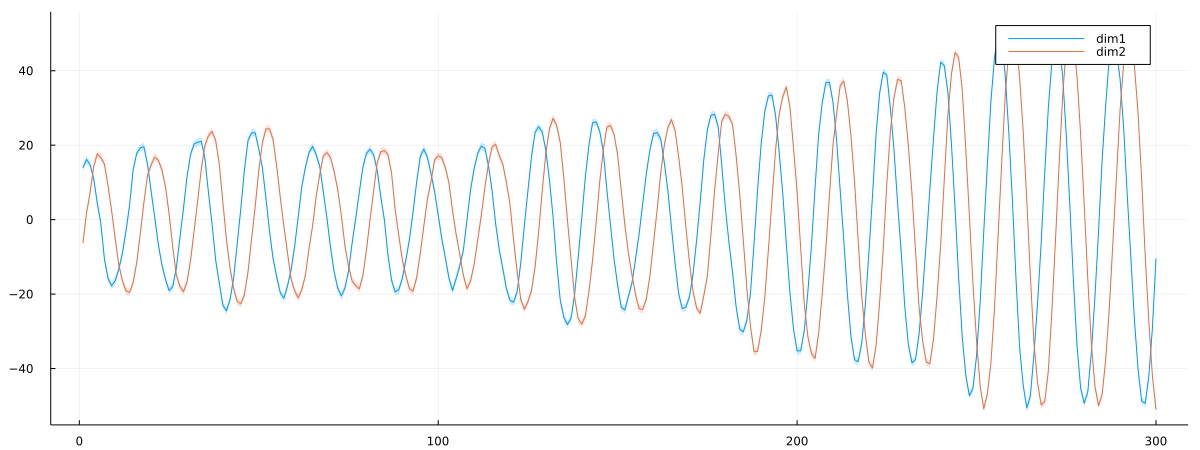

In [11]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "dim1")
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "dim2")

plot(px, size = (1200, 450))

In [12]:
function inference(observations, θ, x0)

    model, (x, y) = rotate_ssm(n, θ, x0, Q, P);

    ms_buffer = Vector{Marginal}(undef, n)
    fe_buffer = nothing
    
    marginals = getmarginals(x)

    fe_subscription = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)
    ms_subscription = subscribe!(marginals, (ms) -> copyto!(ms_buffer, ms))
    
    update!(y, observations)

    unsubscribe!(ms_subscription)
    unsubscribe!(fe_subscription)
    
    return ms_buffer, fe_buffer
end

inference (generic function with 1 method)

In [ ]:
result = inference(model=Model(rotate_ssm, n, θ[1], x0, Q, P), data=(y=y,), free_energy=true)

In [16]:
function f(θ)
    x0 = MvNormalMeanCovariance([ θ[2], θ[3] ], Matrix(Diagonal(0.01 * ones(2))))
    result = inference(model=Model(rotate_ssm, n, θ[1], x0, Q, P), data=(y=y,), free_energy=true)
    return result.free_energy[end]
end

f (generic function with 1 method)

In [17]:
using Optim

In [18]:
f(zeros(3))

LoadError: MethodError: no method matching inference(; model=ReactiveMP.ModelGenerator{rotate_ssm, Tuple{Int64, Float64, MvNormalMeanCovariance{Float64, Vector{Float64}, Matrix{Float64}}, Matrix{Float64}, Matrix{Float64}}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, Nothing, Nothing, Nothing}((300, 0.0, MvNormalMeanCovariance(
μ: [0.0, 0.0]
Σ: [0.01 0.0; 0.0 0.01]
)
, [1.0 0.0; 0.0 1.0], [1.0 0.0; 0.0 1.0]), Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}(), nothing, nothing, nothing), data=(y = [[13.438498097210777, -7.216619111184029], [16.685756965183774, 1.4389588527959463], [14.210552869882527, 7.225663931912096], [10.174451139328344, 14.308983105787728], [4.55198266264407, 16.194710878153], [0.03573777629970132, 15.561854954979111], [-10.427504729164578, 15.685648661407184], [-17.071314084364797, 10.127330409547264], [-17.63908275438153, 2.876659323687739], [-17.196972776554688, -6.6833786758730165]  …  [26.219597575505645, 42.5377890898601], [6.317464091622799, 48.17300346266638], [-10.813939062434724, 47.07245019142989], [-25.951304571387766, 42.991877350957814], [-39.8650002058327, 28.227095091152336], [-48.857377296401346, 11.10766811172185], [-48.45935399845941, -10.55896815479645], [-40.344037005107396, -28.282689459633126], [-30.604676173875696, -42.06219610842768], [-10.653655105490547, -50.780970244772455]],), free_energy=true)
[0mClosest candidates are:
[0m  inference([91m::Any[39m, [91m::Any[39m, [91m::Any[39m) at In[12]:1[91m got unsupported keyword arguments "model", "data", "free_energy"[39m

In [33]:
res = optimize(f, zeros(3), LBFGS(), Optim.Options(f_tol = 1e-14, g_tol = 1e-12, show_trace = true))

Iter     Function value   Gradient norm 
     0     2.192003e+04     9.032537e+04
 * time: 0.020510196685791016
     1     4.596099e+03     4.422999e+04
 * time: 11.213443040847778
     2     1.237347e+03     3.498283e+02
 * time: 11.999000072479248
     3     1.237151e+03     6.975548e+00
 * time: 12.784431219100952
     4     1.161373e+03     2.305850e+01
 * time: 16.960326194763184
     5     1.161372e+03     1.129086e-03
 * time: 17.70546317100525
     6     1.161372e+03     9.640408e-04
 * time: 21.361399173736572
     7     1.161372e+03     7.134229e-07
 * time: 22.53093719482422
     8     1.161372e+03     0.000000e+00
 * time: 23.333635091781616


 * Status: success

 * Candidate solution
    Final objective value:     1.161372e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.75e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.18e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-14
    |g(x)|                 = 0.00e+00 ≤ 1.0e-12

 * Work counters
    Seconds run:   23  (vs limit Inf)
    Iterations:    8
    f(x) calls:    55
    ∇f(x) calls:   55


In [34]:
println("Real value vs Optimized")
println("Real:      ", θ)
println("Optimized: ", res.minimizer)

Real value vs Optimized
Real:      0.39269908169872414
Optimized: [0.3929332481398145, 10.851626228735956, -11.357240224766064]


In [35]:
@show sin(θ), sin(res.minimizer[1])
@show cos(θ), cos(res.minimizer[1])

(sin(θ), sin(res.minimizer[1])) = (0.3826834323650898, 0.3828997634532203)
(cos(θ), cos(res.minimizer[1])) = (0.9238795325112867, 0.9237898955647155)


(0.9238795325112867, 0.9237898955647155)

In [36]:
xmarginals, fe = inference(y, res.minimizer[1], MvNormalMeanCovariance([ res.minimizer[2], res.minimizer[3] ], Matrix(Diagonal(100.0 * ones(2)))));

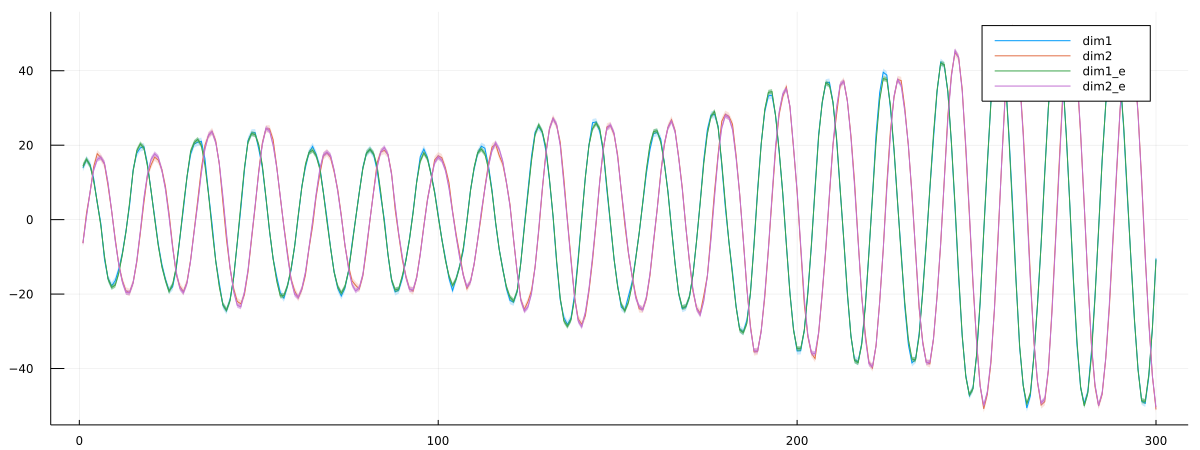

In [37]:
px = plot()

px = plot!(px, x |> slicedim(1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "dim1")
px = plot!(px, x |> slicedim(2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "dim2")
px = plot!(px, mean.(xmarginals) |> slicedim(1), ribbon = var.(xmarginals) |> slicedim(1) .|> sqrt, fillalpha = 0.5, label = "dim1_e")
px = plot!(px, mean.(xmarginals) |> slicedim(2), ribbon = var.(xmarginals) |> slicedim(2) .|> sqrt, fillalpha = 0.5, label = "dim2_e")

plot(px, size = (1200, 450))